In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import xlrd
import pickle
import os as os
from pandas.tseries.offsets import MonthEnd
import datetime
from dotenv import dotenv_values, find_dotenv

# this looks for your configuration file and then reads it as a dictionary
config = dotenv_values(find_dotenv())

# set path using the dictionary key for which one you want
path_cleandata = os.path.abspath(config["CLEANDATA"]) + '\\'
path_rawdata = os.path.abspath(config["RAWDATA"]) + '\\'


In [2]:
fxdat = pd.read_pickle(path_cleandata+'BR_Spot_Fwd_Real'+'.pkl')

In [3]:
# make a country name to iso code dictionary
name_to_ISO = pd.read_csv(path_rawdata+'Country_iso_codes.csv')
# create dictionary from xlsx file with imf to iso codes
name_to_ISO_dict = dict(zip(name_to_ISO['Name'], name_to_ISO['iso3']))

In [4]:
# function to remove outliers from merged data, below

def remove_outliers_fwdspot(startdate, enddate, country):
    tmp = fxdat
    start = pd.to_datetime(startdate, infer_datetime_format=True)
    end = pd.to_datetime(enddate, infer_datetime_format=True)
    isocode = name_to_ISO_dict[country]
    fxdat.loc[((fxdat['Date']>=start) & (fxdat['Date']<=end)) & (fxdat['iso3'] == isocode),['spot', 'fwd1']] = np.nan


In [5]:
# ----------------------------------------------------------------------
# --------------------------- Corrections ------------------------------
# ----------------------------------------------------------------------
# ----------------------------------------------------------------------
# drop bad spot/fwd rate observations in the merged data
# already done in the reuters forward rates, now removing for all the merged forward/spot data

# indonesia: remove from 29-Dec-2000 to 31-May-2007
remove_outliers_fwdspot('29/12/2000', '31/5/2007', 'Indonesia')
# fake dates to test
#remove_outliers_fwdspot('1997-02-28', '1997-04-30', 'Indonesia')

# south africa: remove from 31-Jul-1985 to 30-Aug-1985
remove_outliers_fwdspot('31/07/1985', '30/08/1985', 'South Africa')

# turkey: remove from 31-Oct-2000 to 30-Nov-2001
remove_outliers_fwdspot('31/10/2000', '30/11/2001', 'Turkey')

# malaysia: remove from 31-Aug-1998 to 30-Jun-2005
remove_outliers_fwdspot('31/08/1998', '30/06/2005', 'Malaysia')

# UAE: remove from 30-Jun-2006 to 30-Nov-2006
remove_outliers_fwdspot('30/06/2006', '30/11/2006', 'United Arab Emirates')

In [6]:
fxdat.loc[fxdat['iso3'] == 'DEU']

,iso3,Date,spot,fwd1,cpi,cpius
6,DEU,1983-01-31,NaN,NaN,52.6,97.900
109,DEU,1983-02-28,NaN,NaN,52.7,98.000
212,DEU,1983-03-31,NaN,NaN,52.5,98.100
315,DEU,1983-04-30,NaN,NaN,52.7,98.800
418,DEU,1983-05-31,NaN,NaN,52.9,99.200
...,...,...,...,...,...,...
50494,DEU,2022-11-30,NaN,NaN,113.7,298.598
50600,DEU,2022-12-31,NaN,NaN,113.2,298.990
50706,DEU,2023-01-31,NaN,NaN,114.3,300.536
50812,DEU,2023-02-28,NaN,NaN,115.2,301.648


In [7]:
# ----------------------------------------------------------------------
# ----------------------- Calculate FX values --------------------------
# ----------------------------------------------------------------------
# ----------------------------------------------------------------------

# previous period forward rates and risk premia
fxdat['lagfwd'] = fxdat.groupby('iso3')['fwd1'].shift(1)
fxdat['logrx'] = np.log(fxdat['lagfwd']/fxdat['spot'])
fxdat['forwardspread'] = np.log(fxdat['fwd1']/fxdat['spot'])

## inflation expectations
fxdat['logcpi'] = np.log(fxdat['cpi'])
fxdat['yoycpi'] = fxdat['logcpi'] - fxdat.groupby('iso3')['logcpi'].shift(12)
## lagged year over year change in np.log cpi
fxdat['inflationexpectation'] = fxdat.groupby('iso3')['yoycpi'].shift(1) / 12

## inflation expectations (US)
fxdat['logcpius'] = np.log(fxdat['cpius'])
fxdat['yoycpius'] = fxdat['logcpius'] - fxdat.groupby('iso3')['logcpius'].shift(12) 
## lagged year over year change in np.log cpi
fxdat['inflationexpectationus'] = fxdat.groupby('iso3')['yoycpius'].shift(1) / 12

## real log differential assuming cip
fxdat['realfwdspread'] = fxdat['forwardspread'] - fxdat['inflationexpectation'] + fxdat['inflationexpectationus']

## next periods realized excess return
fxdat['nextrx'] = fxdat.groupby('iso3')['logrx'].shift(-1)



In [8]:
# add year column
fxdat['year'] = fxdat['Date'].dt.year

In [9]:
# sort by country and date
fxdat.sort_values(by=['iso3', 'Date'], inplace=True)

In [10]:
# save
fxdat.to_pickle(path_cleandata+'FX_Data_Clean'+'.pkl')

In [11]:
fxdat.sort_values(['iso3','Date'],inplace=True)

In [12]:
fxdat[(fxdat['iso3']=='NZL')&(fxdat['fwd1'].notnull())]

,iso3,Date,spot,fwd1,cpi,cpius,lagfwd,logrx,forwardspread,logcpi,yoycpi,inflationexpectation,logcpius,yoycpius,inflationexpectationus,realfwdspread,nextrx,year
6281,NZL,1988-01-31,1.5209,1.5338,515.600000,116.000,NaN,NaN,0.008446,6.245331,0.085813,0.007307,4.753590,0.040463,0.003534,0.004673,0.019820,1988
6387,NZL,1988-02-29,1.5037,1.5174,516.966667,116.200,1.5338,0.019820,0.009070,6.247978,0.077601,0.007151,4.755313,0.038601,0.003372,0.005290,-0.007616,1988
6493,NZL,1988-03-31,1.5290,1.5402,518.333333,116.500,1.5174,-0.007616,0.007298,6.250619,0.069498,0.006467,4.757891,0.037608,0.003217,0.004048,0.035152,1988
6599,NZL,1988-04-30,1.4870,1.4981,519.700000,117.200,1.5402,0.035152,0.007437,6.253252,0.061503,0.005792,4.763882,0.039152,0.003134,0.004779,0.036781,1988
6705,NZL,1988-05-31,1.4440,1.4572,521.233333,117.500,1.4981,0.036781,0.009100,6.256198,0.059211,0.005125,4.766438,0.039051,0.003263,0.007237,-0.029215,1988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44759,NZL,2018-04-30,1.4185,1.4185,1015.000000,250.227,1.3846,-0.024189,0.000000,6.922644,0.014889,0.001131,5.522369,0.024410,0.001920,0.000789,-0.006745,2018
44865,NZL,2018-05-31,1.4281,1.4281,1018.000000,250.792,1.4185,-0.006745,0.000000,6.925595,0.016208,0.001241,5.524624,0.027439,0.002034,0.000793,-0.033939,2018
44971,NZL,2018-06-30,1.4774,1.4774,1021.000000,251.018,1.4281,-0.033939,0.000000,6.928538,0.017521,0.001351,5.525525,0.027689,0.002287,0.000936,0.006179,2018
45077,NZL,2018-07-31,1.4683,1.4683,1024.000000,251.214,1.4774,0.006179,0.000000,6.931472,0.018828,0.001460,5.526305,0.028142,0.002307,0.000847,-0.028600,2018


In [13]:
fxdat['spotChange'] = np.log(fxdat['spot'])-np.log(fxdat.groupby('iso3')['spot'].shift(1))

fxdat['test'] = fxdat['logrx']+fxdat['spotChange']
fxdat['test']=fxdat.groupby('iso3')['test'].shift(-1)


In [14]:
fxdat[(fxdat['iso3']=='NZL')&(fxdat['fwd1'].notnull())][['Date','spot','fwd1','lagfwd','logrx','forwardspread','spotChange','test']]

,Date,spot,fwd1,lagfwd,logrx,forwardspread,spotChange,test
6281,1988-01-31,1.5209,1.5338,NaN,NaN,0.008446,NaN,8.446051e-03
6387,1988-02-29,1.5037,1.5174,1.5338,0.019820,0.009070,-0.011374,9.069606e-03
6493,1988-03-31,1.5290,1.5402,1.5174,-0.007616,0.007298,0.016685,7.298351e-03
6599,1988-04-30,1.4870,1.4981,1.5402,0.035152,0.007437,-0.027853,7.436971e-03
6705,1988-05-31,1.4440,1.4572,1.4981,0.036781,0.009100,-0.029344,9.099746e-03
...,...,...,...,...,...,...,...,...
44759,2018-04-30,1.4185,1.4185,1.3846,-0.024189,0.000000,0.024189,6.071532e-18
44865,2018-05-31,1.4281,1.4281,1.4185,-0.006745,0.000000,0.006745,-6.938894e-18
44971,2018-06-30,1.4774,1.4774,1.4281,-0.033939,0.000000,0.033939,1.647987e-17
45077,2018-07-31,1.4683,1.4683,1.4774,0.006179,0.000000,-0.006179,-6.938894e-18


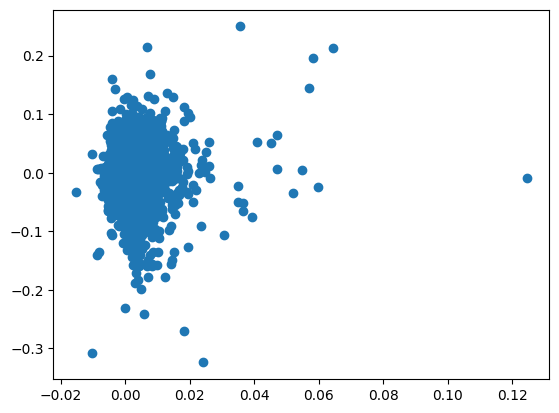

In [15]:
import matplotlib.pyplot as plt
plt.scatter(fxdat['forwardspread'],fxdat['logrx'])